# Imports ⬇

In [ ]:
from scipy.io import wavfile

import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# wav_path = "/content/drive/MyDrive/cs/cs171/project/audio/Lil Uzi Vert_Just Wanna Rock.wav"

# sr, data = wavfile.read(wav_path)

# print("Sample rate:", sr)

# print("Shape:", data.shape)


Sample rate: 44100
Shape: (5471232, 2)


In [ ]:
print("Dtype:", data.dtype)

Dtype: int16


In [ ]:
print("Min value:", data.min())

Min value: -32768


In [ ]:
print("Max value:", data.max())

Max value: 32767


In [ ]:
print("Mean abs value:", np.mean(np.abs(data)))

Mean abs value: 8803.636256331298


In [ ]:
# Convert stereo to mono

if len(data.shape) == 2:
    mono = data.mean(axis=1)
else:
    mono = data

print("Mono shape:", mono.shape)

Mono shape: (5471232,)


In [ ]:
print("First 10 samples:", mono[:10]) # sanity check

First 10 samples: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
print(mono[10000:10100])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
max_abs = np.max(np.abs(mono))
print("Max abs before normalization:", max_abs)

mono_norm = mono / max_abs

Max abs before normalization: 32768.0


In [ ]:
mono_norm = mono / max_abs

print("Min after normalization:", mono_norm.min())

Min after normalization: -1.0


In [ ]:
print("Max after normalization:", mono_norm.max())

Max after normalization: 0.999969482421875


In [ ]:
print("First 10 samples after normalization:", mono_norm[:10])

First 10 samples after normalization: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
duration = len(mono_norm) / sr

print("Duration (seconds):", duration)

t = np.arange(len(mono_norm)) / sr


Duration (seconds): 124.06421768707483


In [ ]:
seconds = 10  # show first 10 seconds

end_sample = int(seconds * sr)

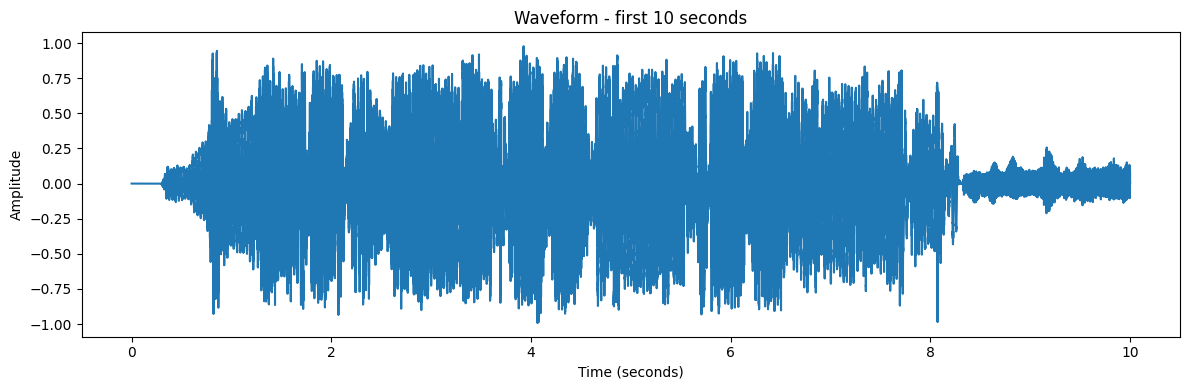

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(t[:end_sample], mono_norm[:end_sample])
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.title(f"Waveform - first {seconds} seconds")
plt.tight_layout()
plt.show()

In [ ]:
analysis_seconds = 30

analysis_end_sample = int(analysis_seconds * sr)

mono_30 = mono_norm[:analysis_end_sample]


t_30 = np.arange(len(mono_30)) / sr

In [ ]:
print("30-sec shape:", mono_30.shape)
print("30-sec duration (sec):", len(mono_30) / sr)


30-sec shape: (1323000,)
30-sec duration (sec): 30.0


In [ ]:
# Spectrogram

mono_30 = mono_norm[:analysis_end_sample]

n_fft = 2048

hop_length = 512

window = np.hanning(n_fft)

In [ ]:
mono_30

array([0.    , 0.    , 0.    , ..., 0.2014, 0.2223, 0.2077])

In [ ]:
num_frames = 1 + (len(mono_30) - n_fft) // hop_length

In [ ]:
num_frames

2580

In [ ]:
stft_matrix = np.zeros((n_fft // 2 + 1, num_frames), dtype=np.complex64)

In [ ]:
stft_matrix

array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],
      dtype=complex64)

In [ ]:
for i in range(num_frames):
    start = i * hop_length
    frame = mono_30[start:start + n_fft]
    frame_windowed = frame * window
    stft_matrix[:, i] = np.fft.rfft(frame_windowed)

In [ ]:
magnitude = np.abs(stft_matrix)

In [ ]:
magnitude

array([[0.    , 0.    , 0.    , ..., 9.2134, 5.9563, 2.5054],
       [0.    , 0.    , 0.    , ..., 6.1905, 2.9771, 3.131 ],
       [0.    , 0.    , 0.    , ..., 5.2131, 0.9767, 3.9812],
       ...,
       [0.    , 0.    , 0.    , ..., 0.008 , 0.0011, 0.0004],
       [0.    , 0.    , 0.    , ..., 0.0079, 0.0012, 0.0003],
       [0.    , 0.    , 0.    , ..., 0.0077, 0.001 , 0.0002]],
      dtype=float32)

In [ ]:
spectrogram_db = 20 * np.log10(magnitude + 1e-10)

In [ ]:
spectrogram_db

array([[-200.    , -200.    , -200.    , ...,   19.2884,   15.4995,
           7.9776],
       [-200.    , -200.    , -200.    , ...,   15.8345,    9.4759,
           9.9138],
       [-200.    , -200.    , -200.    , ...,   14.3419,   -0.2048,
          12.0003],
       ...,
       [-200.    , -200.    , -200.    , ...,  -41.9276,  -59.1558,
         -67.3587],
       [-200.    , -200.    , -200.    , ...,  -42.0625,  -58.2179,
         -70.1372],
       [-200.    , -200.    , -200.    , ...,  -42.2585,  -60.1274,
         -75.2028]], dtype=float32)

In [ ]:
times = np.arange(num_frames) * hop_length / sr
freqs = np.fft.rfftfreq(n_fft, d=1/sr)

In [ ]:
times

array([ 0.    ,  0.0116,  0.0232, ..., 29.9189, 29.9305, 29.9421])

In [ ]:
freqs

array([    0.    ,    21.5332,    43.0664, ..., 22006.9336, 22028.4668,
       22050.    ])

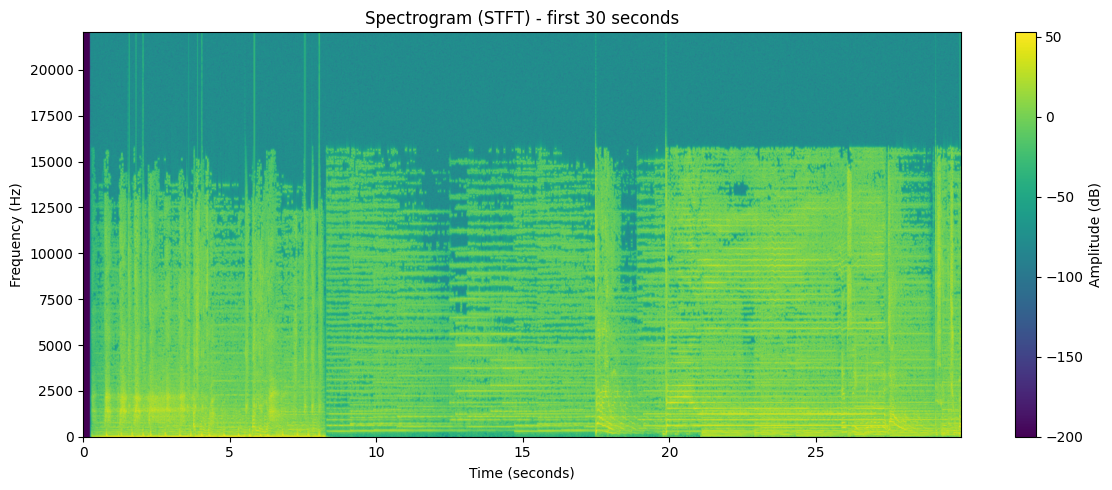

In [ ]:
plt.figure(figsize=(12, 5))
plt.imshow(
    spectrogram_db,
    origin="lower",
    aspect="auto",
    extent=[times[0], times[-1], freqs[0], freqs[-1]]
)
plt.colorbar(label="Amplitude (dB)")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram (STFT) - first 30 seconds")
plt.tight_layout()
plt.show()

In [ ]:
# band energy ratio

In [ ]:
low_max = 250
mid_max = 4000

In [ ]:
low_idx  = np.where(freqs <= low_max)[0]
mid_idx  = np.where((freqs > low_max) & (freqs <= mid_max))[0]
high_idx = np.where(freqs > mid_max)[0]

In [ ]:
print("Number of bins - low:", len(low_idx),
      "mid:", len(mid_idx),
      "high:", len(high_idx))

Number of bins - low: 12 mid: 174 high: 839


In [ ]:
power = magnitude ** 2

In [ ]:
power

array([[ 0.    ,  0.    ,  0.    , ..., 84.8872, 35.4776,  6.2771],
       [ 0.    ,  0.    ,  0.    , ..., 38.3225,  8.8632,  9.8034],
       [ 0.    ,  0.    ,  0.    , ..., 27.1762,  0.9539, 15.85  ],
       ...,
       [ 0.    ,  0.    ,  0.    , ...,  0.0001,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.0001,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.0001,  0.    ,  0.    ]],
      dtype=float32)

In [ ]:
low_energy  = power[low_idx, :].sum()
mid_energy  = power[mid_idx, :].sum()
high_energy = power[high_idx, :].sum()

In [ ]:
total_energy = low_energy + mid_energy + high_energy

In [ ]:
total_energy

np.float32(122681030.0)

In [ ]:
low_ratio  = low_energy  / total_energy
mid_ratio  = mid_energy  / total_energy
high_ratio = high_energy / total_energy

In [ ]:
print("Energy ratios (low, mid, high):")
print(low_ratio, mid_ratio, high_ratio)

Energy ratios (low, mid, high):
0.6055962 0.36873198 0.025671834


In [ ]:
# mfcc

In [ ]:
y = mono_30.astype(np.float32)

n_mfcc = 13

mfcc = librosa.feature.mfcc(
    y=y,
    sr=sr,
    n_mfcc=n_mfcc,
    n_fft=n_fft,
    hop_length=hop_length
)

print("MFCC shape:", mfcc.shape)

MFCC shape: (13, 2584)


In [ ]:
mfcc_mean = mfcc.mean(axis=1)
mfcc_std  = mfcc.std(axis=1)

print("MFCC mean:", mfcc_mean)
print("MFCC std :", mfcc_std)

MFCC mean: [-158.9155  101.0973  -38.5167   20.4162  -35.2067   16.9597  -14.7034
    7.607   -10.0504   -7.9136   -9.4168   -7.6739    2.4112]
MFCC std : [82.2468 42.7286 27.4442 20.2573 19.9989 26.2946 19.2279 15.1231 14.179
 15.2747 15.546  12.415   9.9125]


In [ ]:
audio_features = np.concatenate([mfcc_mean, mfcc_std,
                                 np.array([low_ratio, mid_ratio, high_ratio])])

print("Final audio feature vector shape:", audio_features.shape)
print("audio_features:", audio_features)

Final audio feature vector shape: (29,)
audio_features: [-158.9155  101.0973  -38.5167   20.4162  -35.2067   16.9597  -14.7034
    7.607   -10.0504   -7.9136   -9.4168   -7.6739    2.4112   82.2468
   42.7286   27.4442   20.2573   19.9989   26.2946   19.2279   15.1231
   14.179    15.2747   15.546    12.415     9.9125    0.6056    0.3687
    0.0257]


In [ ]:
audio_features = np.concatenate([
    [low_ratio, mid_ratio, high_ratio],
    mfcc_mean,
    mfcc_std
])

print("Final feature vector shape:", audio_features.shape)
print(audio_features)

Final feature vector shape: (29,)
[   0.6056    0.3687    0.0257 -158.9155  101.0973  -38.5167   20.4162
  -35.2067   16.9597  -14.7034    7.607   -10.0504   -7.9136   -9.4168
   -7.6739    2.4112   82.2468   42.7286   27.4442   20.2573   19.9989
   26.2946   19.2279   15.1231   14.179    15.2747   15.546    12.415
    9.9125]


In [ ]:
np.set_printoptions(suppress=True, precision=4)

names = (
    [f"mfcc_mean_{i+1}" for i in range(13)] +
    [f"mfcc_std_{i+1}"  for i in range(13)] +
    ["low_ratio", "mid_ratio", "high_ratio"]
)

print("Final audio feature vector shape:", audio_features.shape)
print("--------------------------------------------------")

for i, (name, val) in enumerate(zip(names, audio_features)):
    print(f"{i:2d}. {name:12s} -> {val:8.4f}")


Final audio feature vector shape: (29,)
--------------------------------------------------
 0. mfcc_mean_1  ->   0.6056
 1. mfcc_mean_2  ->   0.3687
 2. mfcc_mean_3  ->   0.0257
 3. mfcc_mean_4  -> -158.9155
 4. mfcc_mean_5  -> 101.0973
 5. mfcc_mean_6  -> -38.5167
 6. mfcc_mean_7  ->  20.4162
 7. mfcc_mean_8  -> -35.2067
 8. mfcc_mean_9  ->  16.9597
 9. mfcc_mean_10 -> -14.7034
10. mfcc_mean_11 ->   7.6070
11. mfcc_mean_12 -> -10.0504
12. mfcc_mean_13 ->  -7.9136
13. mfcc_std_1   ->  -9.4168
14. mfcc_std_2   ->  -7.6739
15. mfcc_std_3   ->   2.4112
16. mfcc_std_4   ->  82.2468
17. mfcc_std_5   ->  42.7286
18. mfcc_std_6   ->  27.4442
19. mfcc_std_7   ->  20.2573
20. mfcc_std_8   ->  19.9989
21. mfcc_std_9   ->  26.2946
22. mfcc_std_10  ->  19.2279
23. mfcc_std_11  ->  15.1231
24. mfcc_std_12  ->  14.1790
25. mfcc_std_13  ->  15.2747
26. low_ratio    ->  15.5460
27. mid_ratio    ->  12.4150
28. high_ratio   ->   9.9125


In [ ]:
# merging everything into one function that is shown above

def extract_audio_features(filepath, seconds=30):

    y, sr = librosa.load(filepath, sr=None, mono=True)

    max_samples = int(seconds * sr)
    if len(y) >= max_samples:
        mono_30 = y[:max_samples]
    else:
        mono_30 = y

    max_val = np.max(np.abs(mono_30))
    if max_val > 0:
        mono_30 = mono_30 / max_val

    n_fft = 2048
    hop_length = 512
    window = np.hanning(n_fft)

    if len(mono_30) < n_fft:

        pad_len = n_fft - len(mono_30)
        mono_30 = np.pad(mono_30, (0, pad_len))

    num_frames = 1 + (len(mono_30) - n_fft) // hop_length
    stft_matrix = np.zeros((n_fft // 2 + 1, num_frames), dtype=np.complex64)

    for i in range(num_frames):
        start = i * hop_length
        frame = mono_30[start:start + n_fft]
        if len(frame) < n_fft:
            frame = np.pad(frame, (0, n_fft - len(frame)))
        frame_windowed = frame * window
        stft_matrix[:, i] = np.fft.rfft(frame_windowed)

    magnitude = np.abs(stft_matrix)
    power = magnitude ** 2


    freqs = np.fft.rfftfreq(n_fft, d=1/sr)


    low_max = 250
    mid_max = 4000

    low_idx  = np.where(freqs <= low_max)[0]
    mid_idx  = np.where((freqs > low_max) & (freqs <= mid_max))[0]
    high_idx = np.where(freqs > mid_max)[0]

    low_energy  = power[low_idx, :].sum()
    mid_energy  = power[mid_idx, :].sum()
    high_energy = power[high_idx, :].sum()

    total_energy = low_energy + mid_energy + high_energy + 1e-10

    low_ratio  = low_energy  / total_energy
    mid_ratio  = mid_energy  / total_energy
    high_ratio = high_energy / total_energy


    mfcc = librosa.feature.mfcc(y=mono_30, sr=sr, n_mfcc=13)
    mfcc_mean = mfcc.mean(axis=1)
    mfcc_std  = mfcc.std(axis=1)

    feat = {
        "filename": os.path.basename(filepath),
        "low_ratio":  float(low_ratio),
        "mid_ratio":  float(mid_ratio),
        "high_ratio": float(high_ratio),
    }

    for i, v in enumerate(mfcc_mean, start=1):
        feat[f"mfcc_mean_{i}"] = float(v)

    for i, v in enumerate(mfcc_std, start=1):
        feat[f"mfcc_std_{i}"] = float(v)

    return feat


In [ ]:
# BASE_DIR = "/content/drive/MyDrive/cs/cs171/project/audio"

# BASE_DIR = "audio"

# # file_names = sorted([
#     f for f in os.listdir(BASE_DIR)
#     if f.lower().endswith(".wav")
# ])

# file_paths = [os.path.join(BASE_DIR, name) for name in file_names]

# print("Found", len(file_paths), "wav files:")
# for p in file_paths[:10]:
#     print("  ", p)
# if len(file_paths) > 10:
#     print("  ...")

Found 100 wav files:
   audio/Bad Bunny & Bomba Estereo_Ojitos Lindos.wav
   audio/Bad Bunny & Chencho Corleone_Me Porto Bonito.wav
   audio/Bad Bunny_Efecto.wav
   audio/Bad Bunny_Moscow Mule.wav
   audio/Bad Bunny_Where She Goes.wav
   audio/Bailey Zimmerman_Religiously.wav
   audio/Beyonce_Break My Soul.wav
   audio/Beyonce_Cuff It.wav
   audio/Billie Eilish_What Was I Made For?.wav
   audio/Bizarrap & Shakira_Bzrp Music Sessions, Vol. 53.wav
  ...


In [ ]:
# rows = []
# for path in file_paths:
#     print("\nNow processing:", os.path.basename(path))
#     features = extract_audio_features(path)
#     rows.append(features)


Now processing: Bad Bunny & Bomba Estereo_Ojitos Lindos.wav

Now processing: Bad Bunny & Chencho Corleone_Me Porto Bonito.wav

Now processing: Bad Bunny_Efecto.wav

Now processing: Bad Bunny_Moscow Mule.wav

Now processing: Bad Bunny_Where She Goes.wav

Now processing: Bailey Zimmerman_Religiously.wav

Now processing: Beyonce_Break My Soul.wav

Now processing: Beyonce_Cuff It.wav

Now processing: Billie Eilish_What Was I Made For?.wav

Now processing: Bizarrap & Shakira_Bzrp Music Sessions, Vol. 53.wav

Now processing: CKay_Love Nwantiti (Ah Ah Ah).wav

Now processing: Camila Cabello Featuring Ed Sheeran_Bam Bam.wav

Now processing: Carolina Gaitan, Mauro Castillo, Adassa, Rhenzy Feliz, Diane Guerrero, Stephanie Beatriz & Encanto Cast_We Don't Talk About Bruno.wav

Now processing: Cody Johnson_'Til You Can't.wav

Now processing: Coi Leray_Players.wav

Now processing: David Guetta & Bebe Rexha_I'm Good (Blue).wav

Now processing: Doechii Featuring Kodak Black_What It Is (Block Boy).wav

In [ ]:
# audio_df = pd.DataFrame(rows)
# print("\nDone! DataFrame shape:", audio_df.shape)
# audio_df.head()


Done! DataFrame shape: (100, 30)


,filename,low_ratio,mid_ratio,high_ratio,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,...,mfcc_std_4,mfcc_std_5,mfcc_std_6,mfcc_std_7,mfcc_std_8,mfcc_std_9,mfcc_std_10,mfcc_std_11,mfcc_std_12,mfcc_std_13
0,Bad Bunny & Bomba Estereo_Ojitos Lindos.wav,0.346197,0.642525,0.011278,-209.203079,182.064774,-2.384760,40.098114,-1.102308,6.859410,...,31.488726,23.063513,14.765157,16.040352,12.071749,11.587193,10.576084,10.226146,13.103971,9.926713
1,Bad Bunny & Chencho Corleone_Me Porto Bonito.wav,0.695150,0.298872,0.005978,-232.624329,115.545059,7.741223,28.303684,9.890564,24.111900,...,17.881670,18.928959,14.657878,24.288233,12.170395,11.735451,15.774083,12.665260,12.378710,10.191256
2,Bad Bunny_Efecto.wav,0.617687,0.377578,0.004735,-263.571075,138.516754,10.775500,38.367397,-1.038288,26.877394,...,22.494196,21.434317,22.365084,15.909712,12.626781,13.847604,15.169734,11.067740,12.742627,11.131393
3,Bad Bunny_Moscow Mule.wav,0.638531,0.351680,0.009789,-225.576462,174.453094,11.421305,14.091416,-10.331817,18.045399,...,30.638834,23.767202,25.311769,15.483152,18.084087,16.527193,14.259708,13.576884,10.982653,8.784641
4,Bad Bunny_Where She Goes.wav,0.313138,0.680006,0.006856,-197.028366,199.612717,-5.190522,-15.271994,-9.405279,16.138508,...,36.030533,17.813026,13.758093,16.149559,18.140516,9.774985,8.366125,9.389573,10.150027,11.318231


In [ ]:
# Load pre-computed features for the first 100 songs
# So that professor could access

audio_df = pd.read_csv("audio_features_100songs.csv")
print("Loaded audio_df from CSV:", audio_df.shape)
audio_df.head()


In [ ]:
# audio_df.to_csv("audio_features_100songs.csv", index=False)

In [ ]:
# audio_dir_2 = "/content/drive/MyDrive/cs/cs171/project/audio_2"

# audio_dir_2 = "audio_2"

# wav_files_2 = sorted(glob.glob(os.path.join(audio_dir_2, "*.wav")))
# print("Found files in audio_2:")
# for f in wav_files_2:
#     print("  ", f)

Found files in audio_2:
   audio_2/Alex Warren_Ordinary.wav
   audio_2/Benson Boone_Mystical Magical.wav
   audio_2/Benson Boone_Sorry I'm Here For Someone Else.wav
   audio_2/BigXthaPlug Featuring Bailey Zimmerman_All The Way.wav
   audio_2/Chappell Roan_Pink Pony Club.wav
   audio_2/Charli XCX_Party 4 U.wav
   audio_2/Doja Cat_Jealous Type.wav
   audio_2/HUNTER X, EJAE, AUDREY NUNA, REI AMI, KPop Demon Hunters Cast_Golden.wav
   audio_2/Justin Bieber_Daisies.wav
   audio_2/KATSEYE_Gabriela.wav
   audio_2/Lady Gaga_The Dead Dance.wav
   audio_2/Leon Thomas_Mutt.wav
   audio_2/MGK_Cliché.wav
   audio_2/Morgan Wallen Featuring Tate McRae_What I Want.wav
   audio_2/Myles Smith_Nice To Meet You.wav
   audio_2/Ravyn Lenae_Love Me Not.wav
   audio_2/Sabrina Carpenter_Manchild.wav
   audio_2/Sabrina Carpenter_Tears.wav
   audio_2/Tate McRae_Revolving Door.wav
   audio_2/sombr_Undressed.wav


In [ ]:
# features_2 = []

# for path in wav_files_2:
#     print("\nNow processing (audio_2):", os.path.basename(path))
#     try:
#         feat = extract_audio_features(path, seconds=30)
#         features_2.append(feat)
#     except Exception as e:
#         print("  ERROR on", os.path.basename(path), "->", e)


Now processing (audio_2): Alex Warren_Ordinary.wav

Now processing (audio_2): Benson Boone_Mystical Magical.wav

Now processing (audio_2): Benson Boone_Sorry I'm Here For Someone Else.wav

Now processing (audio_2): BigXthaPlug Featuring Bailey Zimmerman_All The Way.wav

Now processing (audio_2): Chappell Roan_Pink Pony Club.wav

Now processing (audio_2): Charli XCX_Party 4 U.wav

Now processing (audio_2): Doja Cat_Jealous Type.wav

Now processing (audio_2): HUNTER X, EJAE, AUDREY NUNA, REI AMI, KPop Demon Hunters Cast_Golden.wav

Now processing (audio_2): Justin Bieber_Daisies.wav

Now processing (audio_2): KATSEYE_Gabriela.wav

Now processing (audio_2): Lady Gaga_The Dead Dance.wav

Now processing (audio_2): Leon Thomas_Mutt.wav

Now processing (audio_2): MGK_Cliché.wav

Now processing (audio_2): Morgan Wallen Featuring Tate McRae_What I Want.wav

Now processing (audio_2): Myles Smith_Nice To Meet You.wav

Now processing (audio_2): Ravyn Lenae_Love Me Not.wav

Now processing (audio_

In [ ]:
# df_audio2 = pd.DataFrame(features_2)

# print("\n=== audio_2 features head() ===")
# display(df_audio2.head())


=== audio_2 features head() ===


,filename,low_ratio,mid_ratio,high_ratio,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,...,mfcc_std_4,mfcc_std_5,mfcc_std_6,mfcc_std_7,mfcc_std_8,mfcc_std_9,mfcc_std_10,mfcc_std_11,mfcc_std_12,mfcc_std_13
0,Alex Warren_Ordinary.wav,0.368930,0.626933,0.004137,-258.834229,162.908142,11.320369,25.526335,-2.733947,15.444230,...,25.560108,16.888374,18.649380,11.690351,15.146327,14.087523,14.928558,9.794117,8.185650,10.738557
1,Benson Boone_Mystical Magical.wav,0.595020,0.365684,0.039296,-136.206650,137.886337,-18.755941,46.967278,-6.521931,21.431520,...,24.664474,20.329889,17.924377,14.148984,15.071345,11.634433,11.046006,10.516715,10.475721,10.635731
2,Benson Boone_Sorry I'm Here For Someone Else.wav,0.610297,0.363638,0.026064,-131.519379,138.922195,-24.253498,43.274277,-14.501987,23.953312,...,24.088606,16.557217,15.110559,13.420815,14.555690,11.966599,10.668346,9.817291,11.792492,10.317224
3,BigXthaPlug Featuring Bailey Zimmerman_All The...,0.193080,0.760496,0.046424,-171.914688,148.406464,-22.979265,38.494991,-24.726328,17.454504,...,29.692497,24.377384,19.540934,18.930807,13.422353,13.518588,12.572927,10.557369,11.910135,9.328650
4,Chappell Roan_Pink Pony Club.wav,0.304344,0.687346,0.008310,-257.841309,177.391602,15.980700,20.229755,-6.018373,15.221737,...,30.781849,18.470741,11.902449,14.179115,9.928160,9.885686,10.218414,8.777418,11.361154,8.210282


In [ ]:
# print("\nShape:", df_audio2.shape)


Shape: (20, 30)


In [ ]:
# csv_path_2 = "/content/drive/MyDrive/cs/cs171/project/audio_features_audio2.csv"

# csv_path_2 = "audio_features_audio2.csv"

# df_audio2.to_csv(csv_path_2, index=False)
# print("\nSaved to:", csv_path_2)



Saved to: audio_features_audio2.csv


In [ ]:
# Load pre-computed features for the extra 20 songs (audio_2)
# so that professor could access

df_audio2 = pd.read_csv("audio_features_audio2.csv")
print("Loaded df_audio2 from CSV:", df_audio2.shape)
df_audio2.head()


In [ ]:
print(audio_df.columns.tolist())
audio_df.head()

['filename', 'low_ratio', 'mid_ratio', 'high_ratio', 'mfcc_mean_1', 'mfcc_mean_2', 'mfcc_mean_3', 'mfcc_mean_4', 'mfcc_mean_5', 'mfcc_mean_6', 'mfcc_mean_7', 'mfcc_mean_8', 'mfcc_mean_9', 'mfcc_mean_10', 'mfcc_mean_11', 'mfcc_mean_12', 'mfcc_mean_13', 'mfcc_std_1', 'mfcc_std_2', 'mfcc_std_3', 'mfcc_std_4', 'mfcc_std_5', 'mfcc_std_6', 'mfcc_std_7', 'mfcc_std_8', 'mfcc_std_9', 'mfcc_std_10', 'mfcc_std_11', 'mfcc_std_12', 'mfcc_std_13']


,filename,low_ratio,mid_ratio,high_ratio,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,...,mfcc_std_4,mfcc_std_5,mfcc_std_6,mfcc_std_7,mfcc_std_8,mfcc_std_9,mfcc_std_10,mfcc_std_11,mfcc_std_12,mfcc_std_13
0,Bad Bunny & Bomba Estereo_Ojitos Lindos.wav,0.346197,0.642525,0.011278,-209.203079,182.064774,-2.384760,40.098114,-1.102308,6.859410,...,31.488726,23.063513,14.765157,16.040352,12.071749,11.587193,10.576084,10.226146,13.103971,9.926713
1,Bad Bunny & Chencho Corleone_Me Porto Bonito.wav,0.695150,0.298872,0.005978,-232.624329,115.545059,7.741223,28.303684,9.890564,24.111900,...,17.881670,18.928959,14.657878,24.288233,12.170395,11.735451,15.774083,12.665260,12.378710,10.191256
2,Bad Bunny_Efecto.wav,0.617687,0.377578,0.004735,-263.571075,138.516754,10.775500,38.367397,-1.038288,26.877394,...,22.494196,21.434317,22.365084,15.909712,12.626781,13.847604,15.169734,11.067740,12.742627,11.131393
3,Bad Bunny_Moscow Mule.wav,0.638531,0.351680,0.009789,-225.576462,174.453094,11.421305,14.091416,-10.331817,18.045399,...,30.638834,23.767202,25.311769,15.483152,18.084087,16.527193,14.259708,13.576884,10.982653,8.784641
4,Bad Bunny_Where She Goes.wav,0.313138,0.680006,0.006856,-197.028366,199.612717,-5.190522,-15.271994,-9.405279,16.138508,...,36.030533,17.813026,13.758093,16.149559,18.140516,9.774985,8.366125,9.389573,10.150027,11.318231


# ML

In [ ]:
feature_cols = [c for c in audio_df.columns if c != "filename"]
X = audio_df[feature_cols].values

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

In [ ]:
audio_df["cluster"] = cluster_labels

In [ ]:
print("Cluster counts:")
print(audio_df["cluster"].value_counts().sort_index())
print()
print(audio_df[["filename", "cluster"]].head())

Cluster counts:
cluster
0    36
1    38
2    26
Name: count, dtype: int64

                                           filename  cluster
0       Bad Bunny & Bomba Estereo_Ojitos Lindos.wav        2
1  Bad Bunny & Chencho Corleone_Me Porto Bonito.wav        0
2                              Bad Bunny_Efecto.wav        0
3                         Bad Bunny_Moscow Mule.wav        0
4                      Bad Bunny_Where She Goes.wav        2


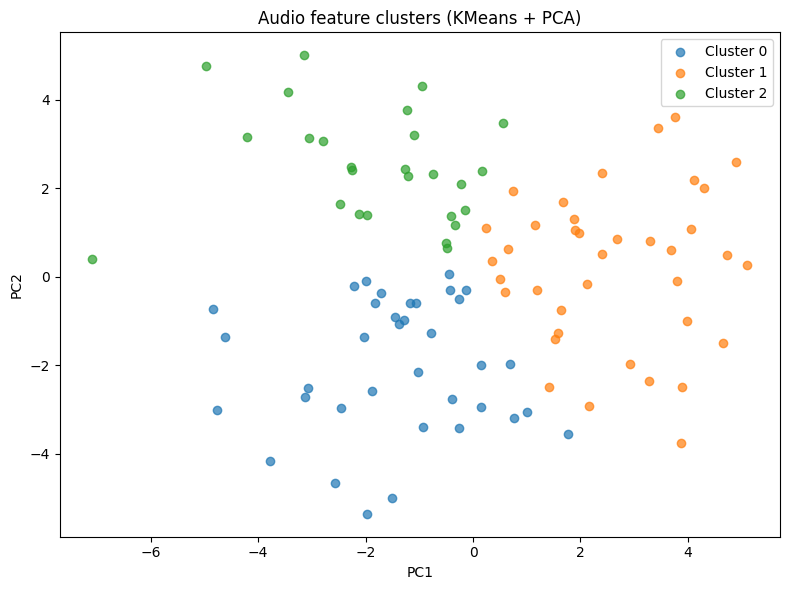

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

audio_df["pc1"] = X_pca[:, 0]
audio_df["pc2"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
for k in sorted(audio_df["cluster"].unique()):
    subset = audio_df[audio_df["cluster"] == k]
    plt.scatter(subset["pc1"], subset["pc2"], label=f"Cluster {k}", alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Audio feature clusters (KMeans + PCA)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
top30_list = [
    "Taylor Swift_Anti-Hero.wav",
    "SZA_Kill Bill.wav",
    "Olivia Rodrigo_Vampire.wav",
    "Billie Eilish_What Was I Made For?.wav",
    "Ice Spice & Nicki Minaj_Princess Diana.wav",
    "Nicki Minaj_Super Freaky Girl.wav",
    "Nicki Minaj & Ice Spice With Aqua_Barbie World.wav",
    "Harry Styles_As It was.wav",
    "Beyonce_Break My Soul.wav",
    "Post Malone_Chemical.wav",
    "Post Malone Featuring Doja Cat_I Like You (A Happier Song).wav",
    "Metro Boomin, Future & Chris Brown_Superhero (Heroes & Villains).wav",
    "David Guetta & Bebe Rexha_I'm Good (Blue).wav",
    "Doechii Featuring Kodak Black_What It Is (Block Boy).wav",
    "Gunna & Future Featuring Young Thug_Pushin P.wav",
    "Bad Bunny_Moscow Mule.wav",
    "Bad Bunny_Where She Goes.wav",
    "Karol G x Shakira_TQG.wav",
    "Peso Pluma X Natanael Cano_PRC.wav",
    "Rema & Selena Gomez_Calm Down.wav",
    "JVKE_Golden Hour.wav",
    "Jack Harlow_First Class.wav",
    "Lizzo_About Damn Time.wav",
    "Sam Smith & Kim Petras_Unholy.wav",
    "Luke Combs_Going, Going, Gone.wav",
    "Morgan Wallen_You Proof.wav",
    "Morgan Wallen_Thinkin’ Bout Me.wav",
    "Noah Kahan With Post Malone_Dial Drunk.wav",
    "OneRepublic_I Ain't Worried.wav",
    "Nicky Youre & dazy_Sunroof.wav"
]

In [ ]:
audio_df["top30"] = audio_df["filename"].isin(top30_list).astype(int)

In [ ]:
feature_cols = [c for c in audio_df.columns if c not in ["filename", "top30"]]
X = audio_df[feature_cols].values
y = audio_df["top30"].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2000)

In [ ]:
y_pred = model.predict(X_test)

print("Train accuracy:", accuracy_score(y_train, model.predict(X_train)))
print("Test  accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

Train accuracy: 0.875
Test  accuracy: 0.35

Confusion matrix:
 [[6 8]
 [5 1]]

Classification report:
               precision    recall  f1-score   support

           0       0.55      0.43      0.48        14
           1       0.11      0.17      0.13         6

    accuracy                           0.35        20
   macro avg       0.33      0.30      0.31        20
weighted avg       0.42      0.35      0.38        20



In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

In [ ]:
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

print("\n=== Random Forest Results ===")
print("Train accuracy:", accuracy_score(y_train, rf_model.predict(X_train)))
print("Test  accuracy:", accuracy_score(y_test, rf_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, rf_pred))
print("\nClassification report:\n", classification_report(y_test, rf_pred))


=== Random Forest Results ===
Train accuracy: 1.0
Test  accuracy: 0.55

Confusion matrix:
 [[11  3]
 [ 6  0]]

Classification report:
               precision    recall  f1-score   support

           0       0.65      0.79      0.71        14
           1       0.00      0.00      0.00         6

    accuracy                           0.55        20
   macro avg       0.32      0.39      0.35        20
weighted avg       0.45      0.55      0.50        20



In [ ]:
importance_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

print("\nTop 10 most important audio features:")
display(importance_df.head(10))


Top 10 most important audio features:


,feature,importance
16,mfcc_std_1,0.075886
23,mfcc_std_8,0.058402
11,mfcc_mean_9,0.047344
8,mfcc_mean_6,0.044310
27,mfcc_std_12,0.039319
22,mfcc_std_7,0.038849
21,mfcc_std_6,0.036956
30,pc1,0.034929
18,mfcc_std_3,0.033499
17,mfcc_std_2,0.033326


### Data collection and preprocessing

This notebook documents how I obtained and prepared the audio data that our group uses in the final model.

#### 1. Song selection
- I started from our group’s Billboard song list and chose **100 songs** that we already use in the main project.
- For each of these songs I checked that an audio file was available and could be downloaded.
- In addition, I prepared **20 extra songs** that are not in the original 100.  
  These are used as a small “new songs” set for later prediction experiments.

#### 2. Audio acquisition
- For every selected track I downloaded the audio and converted it to **WAV** format.
- I kept a fixed-length clip (about the first 30 seconds) for each song.
- Files were organized into two folders:
  - `audio_wav/`  – main set of 100 songs  
  - `audio_wav_2/` – extra set of 20 songs

#### 3. Standardization / cleaning
- All clips were converted to a **single mono channel**.
- The sample rate was standardized (e.g., 44.1 kHz), and the waveform was rescaled so that amplitudes stay in the range **[-1, 1]**.
- This makes the features comparable across different songs.

#### 4. Feature extraction
For each WAV file the notebook runs the same feature pipeline:

1. Compute a **spectrogram (STFT)** of the clip.  
2. From the spectrogram, calculate **3 band-energy ratios**:
   - Bass / low band
   - Mid / vocal band
   - High / cymbal band
3. Compute **13 MFCC coefficients** over the clip and record:
   - the **mean** of each MFCC  
   - the **standard deviation** of each MFCC  

In total this gives **29 numeric features per song**  
(3 band-energy ratios + 13 MFCC means + 13 MFCC standard deviations).

#### 5. Feature tables (CSVs)
- For the 100-song folder (`audio_wav/`), all extracted features are stored in  
  **`audio_features_100songs.csv`** (100 rows × 29 feature columns).
- For the 20 extra songs (`audio_wav_2/`), the same pipeline is applied and saved as  
  **`audio_features_audio2.csv`** (20 rows × 29 feature columns).
- These two CSV files are what the later modeling notebooks read, so the model can be
  rerun without needing the original WAV files.

#### 6. Label construction for the Top-30 experiment
- Using our project’s Billboard information, I manually created a list of **30 songs**
  that we treated as “Top 30–style” examples.
- In `audio_features_100songs.csv` I added a binary column **`top30`**:
  - `1` if the song is in this Top-30 list  
  - `0` otherwise
- This label is used in my Logistic Regression and Random Forest experiments to
  test how well audio-only features can predict whether a song belongs to the Top-30 group.

---


# Audio Feature-Based Classification Report  
**Predicting Songs with only Audio Features Using Machine Learning**

## 1. Overview
In this experiment, we attempted to predict whether a song belongs to a “Top 30” group using **only audio-based features** extracted from 100 WAV files.  
We intentionally **did not merge** with any lyric-based or external metadata files; all analysis was performed solely on the audio features contained in `audio_df`.  
The purpose of this project was to evaluate whether **acoustic characteristics alone** can meaningfully predict chart success.

---

## 2. Data Description
Each song’s audio was processed to extract a total of **29 numerical audio features**, consisting of:

- **3 Band-Energy Ratios:** low, mid, high  
- **13 MFCC means**  
- **13 MFCC standard deviations**

These features describe spectral energy distribution and detailed timbre characteristics.

A binary label `top30` was created using a manually selected list of 30 songs.  
This label **does not correspond to real Billboard rankings**; it was generated solely for testing audio-based classification performance.

---

## 3. Models Used
We trained and evaluated two machine learning models:

| Model | Type | Notes |
|-------|------|-------|
| **Logistic Regression** | Linear classifier | Attempts to classify using a linear decision boundary |
| **Random Forest Classifier** | Non-linear ensemble | Captures complex, non-linear patterns using multiple decision trees |

Both models used the same 80/20 train-test split.

---

## 4. Results

### 4.1 Logistic Regression
Train Accuracy: 0.875
Test Accuracy : 0.35

- The model fits the training data reasonably well but **fails to generalize**.  
- A test accuracy of **0.35** indicates near-random performance.  
- Audio features do not form a linearly separable boundary for this task.

---

### 4.2 Random Forest
Train Accuracy: 1.00
Test Accuracy : 0.55

- Perfect training accuracy indicates **severe overfitting**.  
- Test accuracy improves to **0.55**, outperforming Logistic Regression.  
- However, recall for class `1` (Top 30) is still extremely low, meaning the model rarely identifies Top 30 songs correctly.

**Feature Importance observations:**
- MFCC **standard deviation features** dominated the top rankings.  
- This implies that **timbre variability** contributes more to the model’s decisions than simple average spectral values.

---

## 5. Interpretation

### What the results suggest
- Audio features contain **some weak predictive signal**, especially in timbre-related characteristics.  
- However, this information is insufficient for reliable Top 30 song identification.

### Why the models struggled
1. **Manually created labels (not true Billboard data)**  
   - Inconsistent or weak mapping between audio features and the assigned label.

2. **Small dataset (100 songs)**  
   - Too small to support generalization and robust model training.

3. **Audio-only limitation**  
   - Chart success depends on lyrics, artist popularity, marketing, genre, culture, etc.  
   - None of these factors are captured by MFCCs or band-energy ratios.

4. **Class imbalance (30 vs 70)**  
   - Reduces the model’s ability to learn minority class patterns.

5. **Model constraints**  
   - Logistic Regression cannot represent non-linear boundaries.  
   - Random Forest easily overfits small datasets.

---

## 6. Conclusion
> Using audio-only features, we trained two machine learning models Logistic Regression and Random Forest to predict whether a song belongs to our manually selected Top 30 list.  
> While Random Forest showed improved performance (0.55 test accuracy), both models demonstrated poor generalization.  
> This suggests that audio spectral features alone cannot reliably predict chart-level success, especially without additional metadata or a larger dataset.

---